<a href="https://colab.research.google.com/github/Luckilyeee/HateSpeech/blob/master/ML_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import files
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [0]:
data = pd.read_csv("labeled_data.csv") 

In [6]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [0]:
# count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
# hate_speech = number of CF users who judged the tweet to be hate speech.
# offensive_language = number of CF users who judged the tweet to be offensive.
# neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [8]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [9]:
# feature names as a list
col = data.columns       # .columns gives columns names in data 
print(col)

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')


In [10]:
#count the number of each class
import matplotlib.pyplot as plt
data['class'].hist

<bound method hist_series of 0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64>

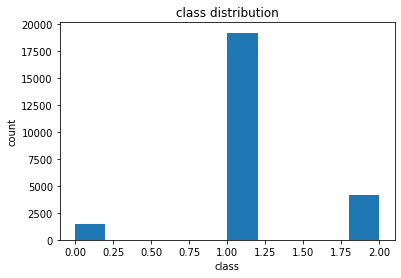

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data['class'])
plt.title('class distribution')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [12]:
#import numpy as np
#import pandas as pd
data = data.rename(columns={'Unnamed: 0':'id'})
data.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [13]:
data.groupby('class').count()[['id']]

,id
class,
0,1430
1,19190
2,4163


In [0]:
data['class'].replace(0, 1, inplace=True)
data['class'].replace(2, 0, inplace=True)

In [15]:

data.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


hate speech or offensive language : 20620
neigher :  4163


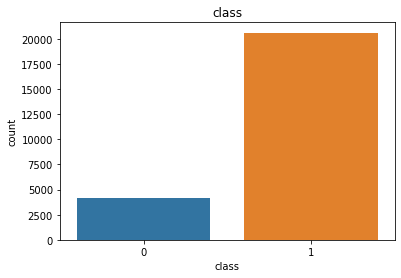

In [16]:
import seaborn as sns
y = data['class']
F, T = y.value_counts()

fig1 = sns.countplot(y,label = 'count')
plt.title('class')
plot = fig1.get_figure()
plot.savefig('Count Plot.png')

print('hate speech or offensive language :',F)
print('neigher : ',T)

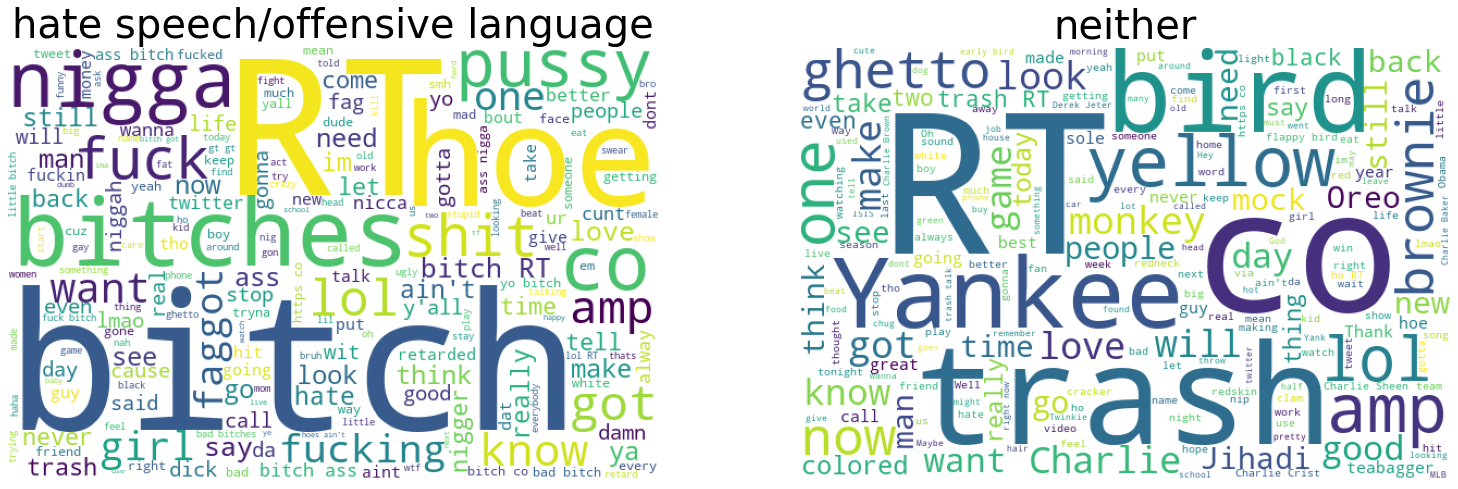

In [17]:
from wordcloud import WordCloud

hatespeech = data[data['class']==1]['tweet']
neither = data[data['class']==0]['tweet']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(hatespeech))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('hate speech/offensive language',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neither))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('neither',fontsize=40);

In [18]:
# remove puctunations, https
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
data_clean = clean_text(data, 'tweet')
data_clean.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,rt as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she start to cry you be confused as shit
3,3,3,0,2,1,1,rt ganderson based she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true or it might be faker than the bitch who told it to ya 57361


In [19]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [20]:

#remove stopwords
stop = stopwords.words('english')
data_clean['tweet'] = data_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,0,rt woman shouldnt complain cleaning house amp man always take trash
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad cuffin dat hoe 1st place
2,2,3,0,3,0,1,rt dawg rt ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,rt ganderson based look like tranny
4,4,6,0,6,0,1,rt shit hear might true might faker bitch told ya 57361


In [0]:
# lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatizer_(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data_clean['tweet'] = data_clean['tweet'].apply(lambda x: lemmatizer_(x))

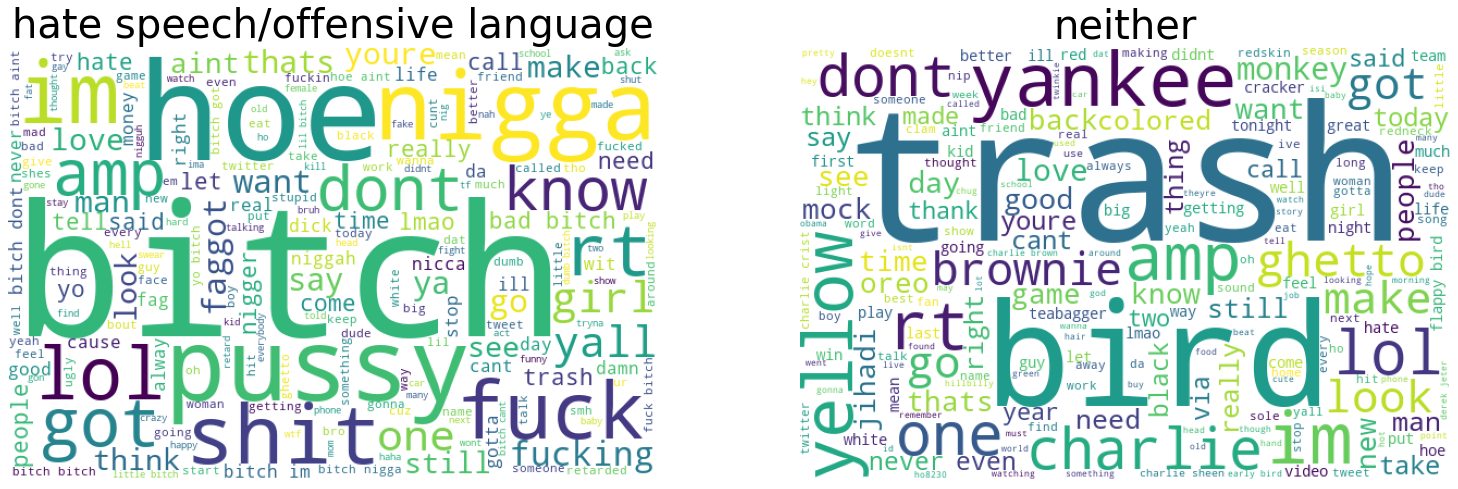

In [22]:
hatespeech = data[data['class']==1]['tweet']
neither = data[data['class']==0]['tweet']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(hatespeech))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('hate speech/offensive language',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neither))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('neither',fontsize=40);

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_clean['tweet'],data_clean['class'],random_state = 0)
#If train_size is None, it will be set to 0.25.

In [24]:
X_train

6455     jason swear u fuck nigga u scary little bitch u think game huh                                    
13493    new bitch acting dumb tryna correct every word                                                    
8003     bet charlie strong contacted ridley                                                               
24732    yal faggot yup nigga n fuckin fruit cup                                                           
18088    boy discover hoe                                                                                  
               ...                                                                                         
13123    partna mississippi told 2weeks ago got 2 week fuck ok hoe 2014 im stepping game 128514128514128514
19648    wish pretty colored eye                                                                           
9845     hoe bandwagon bitch gaggin jet laggin aap                                                         
10799    never played bitch 

In [25]:
y_train

6455     1
13493    1
8003     0
24732    1
18088    1
        ..
13123    1
19648    0
9845     1
10799    1
2732     1
Name: class, Length: 18587, dtype: int64

In [26]:
# NB and TFIDF
pipeline_1 = Pipeline([
    
    ('tfidf', TfidfVectorizer()),  
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model1 = pipeline_1.fit(X_train, y_train)

y_predict1 = model1.predict(X_test)
print(classification_report(y_test, y_predict1))

              precision    recall  f1-score   support

           0       0.96      0.11      0.20      1037
           1       0.85      1.00      0.92      5159

    accuracy                           0.85      6196
   macro avg       0.90      0.55      0.56      6196
weighted avg       0.87      0.85      0.80      6196



In [27]:
confusion_matrix(y_test, y_predict1)

array([[ 115,  922],
       [   5, 5154]])

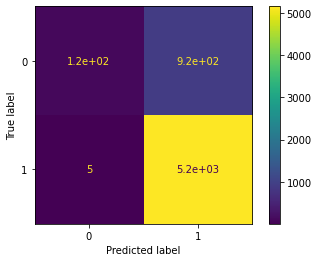

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test)  

In [29]:
# NB and COUNT
pipeline_11 = Pipeline([
    
    ('countv', CountVectorizer()),  
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model11 = pipeline_11.fit(X_train, y_train)

y_predict11 = model11.predict(X_test)
print(classification_report(y_test, y_predict11))

              precision    recall  f1-score   support

           0       0.89      0.57      0.69      1037
           1       0.92      0.99      0.95      5159

    accuracy                           0.92      6196
   macro avg       0.91      0.78      0.82      6196
weighted avg       0.91      0.92      0.91      6196



In [30]:
confusion_matrix(y_test, y_predict11)

array([[ 586,  451],
       [  71, 5088]])

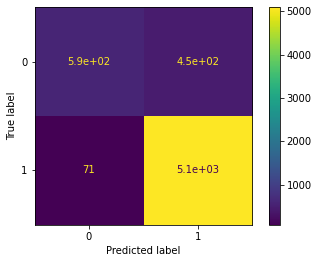

In [31]:
plot_confusion_matrix(model11, X_test, y_test) 

In [32]:
# TfidfVectorizer and SGD classifier
pipeline_2 = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('classifier', SGDClassifier()),
])
model2 = pipeline_2.fit(X_train, y_train)


y_predict2 = model2.predict(X_test)
print(classification_report(y_test, y_predict2))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1037
           1       0.97      0.97      0.97      5159

    accuracy                           0.95      6196
   macro avg       0.90      0.91      0.91      6196
weighted avg       0.95      0.95      0.95      6196



In [33]:
confusion_matrix(y_test, y_predict2)

array([[ 875,  162],
       [ 165, 4994]])

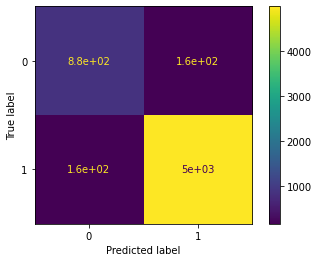

In [34]:
plot_confusion_matrix(model2, X_test, y_test)  

In [35]:
# CountVectorizer and SGD classifier
pipeline_22 = Pipeline([
    ('countv',  CountVectorizer()),
    ('classifier', SGDClassifier()),
])
model22 = pipeline_22.fit(X_train, y_train)


y_predict22 = model22.predict(X_test)
print(classification_report(y_test, y_predict22))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1037
           1       0.97      0.97      0.97      5159

    accuracy                           0.95      6196
   macro avg       0.91      0.91      0.91      6196
weighted avg       0.95      0.95      0.95      6196



In [36]:
confusion_matrix(y_test, y_predict22)

array([[ 895,  142],
       [ 171, 4988]])

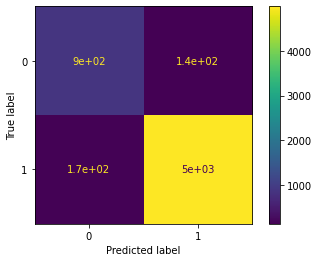

In [37]:
plot_confusion_matrix(model22, X_test, y_test)

In [38]:
#Logistic Regression and TFIDF
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogisticRegression classifier
])
model3 = pipeline_3.fit(X_train, y_train)


y_predict3 = model3.predict(X_test)
print(classification_report(y_test, y_predict3))

              precision    recall  f1-score   support

           0       0.88      0.73      0.79      1037
           1       0.95      0.98      0.96      5159

    accuracy                           0.94      6196
   macro avg       0.91      0.85      0.88      6196
weighted avg       0.94      0.94      0.93      6196



In [39]:
confusion_matrix(y_test, y_predict3)

array([[ 754,  283],
       [ 107, 5052]])

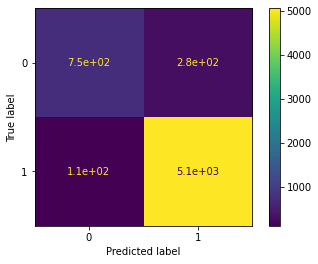

In [40]:
plot_confusion_matrix(model3, X_test, y_test)

In [41]:
#Logistic Regression and CountV
pipeline_33 = Pipeline([
    ('tfidf', CountVectorizer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ LogisticRegression classifier
])
model33 = pipeline_33.fit(X_train, y_train)

y_predict33 = model33.predict(X_test)
print(classification_report(y_test, y_predict33))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1037
           1       0.97      0.97      0.97      5159

    accuracy                           0.95      6196
   macro avg       0.91      0.91      0.91      6196
weighted avg       0.95      0.95      0.95      6196



In [42]:
confusion_matrix(y_test, y_predict33)

array([[ 887,  150],
       [ 169, 4990]])

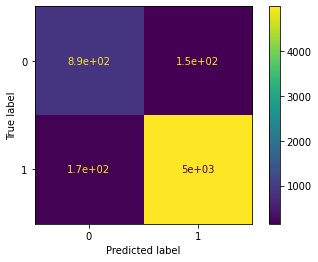

In [43]:
plot_confusion_matrix(model33, X_test, y_test)